# Config
Configurazioni generali dell'addestramento:

In [ ]:
import torch

BATCH_SIZE = 128

NUM_CLASSES = 10
EPOCHS = 10
DEVICE = torch.device("mps")

TRAIN_DATASET_PATH = "dataset_zoo/svhn/train_32x32.mat"
VALID_DATASET_PATH = "dataset_zoo/svhn/test_32x32.mat"

# Rete
La rete sviluppata è una rete convoluzionale molto leggera, con l'unico compito di capire qual'è il numero rappresentato nell'immagine.

La rete presenta una struttura a blocchi formati da:
- Blocco convoluzionale.
- Normalizzazione batch.
- ReLU.
- DropOut.
l'utilizzo di ReLU permette di evitare il problema del Vanishing gradient e il DropOut permette di regolarizzare la rete evitando overfitting.

In [62]:
import torch
import torch.nn as nn

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

class NumberClassifier(nn.Module):
    """
    Classificatore leggero per il dataset SVHN.

    Args:
        num_classes (int): numero di classi in cui classificare le immagini.
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=2, padding=0), # 32x3x3 -> 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0), # 64x16x16 -> 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2, padding=0), # 128x8x8 -> 256x4x4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=2, padding=0), # 256x4x4 -> 512x2x2
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            
            nn.Flatten()
        )  
        self.fc = nn.Linear(512 * 2 * 2, out_features=num_classes)
        self.apply(weights_init)
        
    def forward(self, x: torch.Tensor, features: bool = False) -> torch.Tensor:
        x = self.model(x)
        l = self.fc(x)
        
        if features:
            return l, x
        return l

# Trainer

L'addestramento della rete è relativamente semplice, lo eseguiamo per 10 epoche usando una CrossEntropyLoss e un ottimizzatore Adam con lr impostato a 1e-3.

Per ogni epoca di addestramento verrà anche creata una matrice di confusione.

In [63]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

class NumberClassifierTrainer:
    def __init__(
        self, 
        num_classes: int, 
        device: str
        ):
        self.device = device
        
        self.model = NumberClassifier(num_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
        self.criterion = nn.CrossEntropyLoss()
        
        self.history = {
            "train_loss": [],
            "valid_loss": [],
            "confusion_matrices": []
        }
        
    def __train_step__(
        self,
        images: torch.Tensor, 
        labels: torch.Tensor
        ):
        """
        Step di addestramento del modello.

        Args:
            images (torch.Tensor): tensore contenente il batch di immagini del dataset
            labels (torch.Tensor): tensore contenente il batch di labels del dataset

        Returns:
            torch.Tensor: perdita dello step di addestramento
        """
        
        self.model.train()
        self.optimizer.zero_grad()
        
        preds = self.model(images) # Logits delle labels predette
        
        loss = self.criterion(preds, labels) 
        loss.backward()
        
        self.optimizer.step()
        return loss
        
    def __valid_step__(
        self, 
        images: torch.Tensor, 
        labels: torch.Tensor
        ):
        """
        Step di validazione del modello.

        Args:
            images (torch.Tensor): tensore contenente il batch di immagini del dataset
            labels (torch.Tensor): tensore contenente il batch di labels del dataset

        Returns:
            torch.Tensor: perdita dello step di validazione
            torch.Tensor: tensore contenente le labels predette
            torch.Tensor: tensore contenente le labels target
        """
        self.model.eval()
        with torch.no_grad():
            preds = self.model(images)
            loss = self.criterion(preds, labels)
            
            predicted_labels = preds.argmax(dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()
        
        return loss, predicted_labels, true_labels
    
    def __print_epoch__(
        self,
        epoch: int, 
        epochs: int, 
        train_loss: float, 
        valid_loss: float
        ):
        """
        Stampa il resoconto dell'epoca di addestramento

        Args:
            epoch (_type_): epoca attuale.
            epochs (int, optional): epoche di addestramento.
            train_loss (_type_): perdita di addestramento.
            valid_loss (_type_): perdita di validazione.
        """
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Valid Loss: {valid_loss:.4f}")
        
    def train_loop(
        self, 
        train_dataloader: torch.utils.data.DataLoader, 
        valid_dataloader: torch.utils.data.DataLoader,
        save_path: str,
        epochs: int = 10, 
        patience: int = 5        
        ) -> dict[str, list]:
        """
        Loop di addestramento del modello.

        Args:
            train_dataloader (torch.utils.data.DataLoader): dataset di addestramento
            valid_dataloader (torch.utils.data.DataLoader): dataset di validazione
            save_path (str): percorso di salvataggio
            epochs (int, optional): epoche di addestramento, default 10.

        Returns:
            dict[str, list]: resoconto dell'addestramento.
        """ 
        
        best_valid_loss = float("inf")
        epochs_without_improvement = 0
        for epoch in range(epochs):

            running_train_loss = 0.0
            pb_train_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for batch in pb_train_dataloader:
                loss = self.__train_step__(
                    batch["images"].to(self.device),
                    batch["labels"].to(self.device)
                )
                
                running_train_loss += loss.item()
                pb_train_dataloader.set_postfix(
                    train_loss = running_train_loss  / (pb_train_dataloader.n + 1)
                )
                
            avg_train_loss = running_train_loss / len(train_dataloader)
            self.history["train_loss"].append(avg_train_loss)
                
            running_valid_loss = 0.0
            all_preds, all_labels = [], []
            pb_valid_dataloader = tqdm(valid_dataloader, desc=f"Epoch {epoch+1}/{epoch}", leave=False)
            for batch in pb_valid_dataloader:
                loss, preds, labels = self.__valid_step__(
                    batch["images"].to(self.device),
                    batch["labels"].to(self.device)
                )
                
                running_valid_loss += loss.item()
                all_preds.extend(preds)
                all_labels.extend(labels)
                pb_valid_dataloader.set_postfix(
                    valid_loss = running_valid_loss  / (pb_train_dataloader.n + 1)
                )
                
            avg_valid_loss = running_valid_loss / len(valid_dataloader)
            self.history["valid_loss"].append(avg_valid_loss)
            
            cm = confusion_matrix(all_labels, all_preds, labels=list(range(self.model.num_classes)))
            self.history["confusion_matrices"].append(cm)
                        
            self.__print_epoch__(epoch, epochs, avg_train_loss, avg_valid_loss) 
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                epochs_without_improvement = 0
                torch.save(self.model.state_dict(), save_path)
                print(" --> Modello salvato.")
            else:
                epochs_without_improvement += 1
                print(f" --> Nessun miglioramento per {epochs_without_improvement} epoche.")
                
            if epochs_without_improvement >= patience:
                print(f"Early stopping attivato dopo {epoch+1} epoche.")
                break
        
        return self.history

## Dataset
Il dataset utilizzato è SVHN ovvero un dataset contenente differenti immagini di numeri civici.

In [64]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.io import loadmat

def get_svhn_default_transform():
    """
    Ritorna le trasformazioni di default applicare sulle immagini e sulle annotazioni del dataset
    Street View House Number.
    
    Returns:
        A.Compose
    """
    return A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])
    
class StreetViewHouseNumbersDataset(torch.utils.data.Dataset):
    """
    Classe Dataset per rappresentare Street View House Numbers (SVHN).

    Args:
        file_path (str): Percorso al file .mat contenente il dataset.
        transform (callable, optional): Trasformazioni da applicare alle immagini.
        percentage (float): percentuale di elementi caricati dal dataset
    """
    def __init__(self, mat_file: str): 
        self.name = "Street View House Numbers"
        self.default_transform = get_svhn_default_transform()  

        data = loadmat(mat_file)
        self.images = data['X'] # Le immagini sono in un array 4D (32, 32, 3, N)
        self.labels = data['y'].squeeze() # Le etichette sono in un array 1D (N,)
                
    def __len__(self):
        return self.images.shape[3]
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        image_np = self.images[:, :, :, idx]  # Estrazione dell'immagine        
        transformed = self.default_transform(image = image_np)
        label = self.labels[idx] - 1  # Le etichette sono da 1 a 10, convertiamo in 0-9
        
        target = {
            "image": transformed["image"],
            "label": torch.tensor(label, dtype=torch.long),
        }
        return target

## Start
Di seguito il codice per avviare l'addestramento del classificatore:

In [65]:
def collate_fn(batch):
    images = torch.stack([item["image"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    
    return {
        "images": images,
        "labels": labels
    }
    
train_dataset = StreetViewHouseNumbersDataset(mat_file=TRAIN_DATASET_PATH)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True
)

valid_dataset = StreetViewHouseNumbersDataset(mat_file=VALID_DATASET_PATH)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=True
)
    
trainer = NumberClassifierTrainer(NUM_CLASSES, DEVICE)
trainer.train_loop(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader, 
    save_path="models/cnn/checkpoint/number_classifier.pth",
    epochs=EPOCHS
)


Epoch 1/10
  Train Loss: 1.1209
  Valid Loss: 0.6093
 --> Modello salvato.



Epoch 2/10
  Train Loss: 0.6015
  Valid Loss: 0.5494
 --> Modello salvato.



Epoch 3/10
  Train Loss: 0.5347
  Valid Loss: 0.4767
 --> Modello salvato.



Epoch 4/10
  Train Loss: 0.4817
  Valid Loss: 0.4518
 --> Modello salvato.



Epoch 5/10
  Train Loss: 0.4553
  Valid Loss: 0.4361
 --> Modello salvato.



Epoch 6/10
  Train Loss: 0.4271
  Valid Loss: 0.4208
 --> Modello salvato.



Epoch 7/10
  Train Loss: 0.4105
  Valid Loss: 0.4061
 --> Modello salvato.



Epoch 8/10
  Train Loss: 0.3885
  Valid Loss: 0.3950
 --> Modello salvato.



Epoch 9/10
  Train Loss: 0.3788
  Valid Loss: 0.3921
 --> Modello salvato.



Epoch 10/10
  Train Loss: 0.3622
  Valid Loss: 0.3967
 --> Nessun miglioramento per 1 epoche.


{'train_loss': [1.1208937209281888,
  0.6015318862937548,
  0.5346704097008789,
  0.4816679224319808,
  0.45531547189384075,
  0.4270566623215075,
  0.4105210486096102,
  0.3885175584183706,
  0.3788092736858171,
  0.362227309000242],
 'valid_loss': [0.6093351012967491,
  0.5493552402909754,
  0.47668479478417947,
  0.45183259674480986,
  0.43614946819584943,
  0.42082388655011876,
  0.40608465921115405,
  0.39497707894282974,
  0.39213724265544875,
  0.3966839378837294],
 'confusion_matrices': [array([[4637,   48,   40,   85,   33,   18,   81,   22,   11,  114],
         [ 104, 3557,  128,   68,   76,   30,   82,   36,   39,   21],
         [ 130,   61, 2057,   47,  205,   62,   20,   81,  159,   54],
         [ 103,   42,   58, 2083,   30,   50,   20,   11,   43,   79],
         [  38,   21,  111,   24, 1964,  150,   12,    7,   30,   24],
         [  49,   14,   53,   47,  129, 1480,   13,   42,   26,  117],
         [ 126,   50,   36,   13,   46,    7, 1701,    6,   13,   18],
    

# Visualizzazione
Completato l'addestramento tramite la storia salvata possiamo visualizzare le statistiche di addestramento del dataset:

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

class NumberClassifierVisualizer:
    def __init__(self,
                 train_history: dict[str, list],
                 num_classes: int):
        self.history = train_history
        self.num_classes = num_classes
        
    def plot_losses(self):
        """
        Crea un grafico con le perdite del modello.
        """
        plt.figure(figsize=(8,5))
        plt.plot(self.history["train_loss"], label="Train Loss")
        plt.plot(self.history["valid_loss"], label="Valid Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_cm(self, 
                epoch: int = -1):
        """
        Crea un grafico con la matrice di confusione del modello.

        Args:
            epoch (int, optional): epoca per cui creare il grafico di confusione.
        """
        if epoch >= len(self.history["confusion_matrices"]):
            epoch = -1
            
        cm = self.history["confusion_matrices"][epoch]
                
        plt.figure(figsize=(7,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=list(range(self.num_classes)),
                    yticklabels=list(range(self.num_classes)))
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix (epoch {epoch if epoch>=0 else len(self.history['confusion_matrices'])})")
        plt.show()

## Start
Di seguito il codice per visulalizzare le statistiche del classificatore:

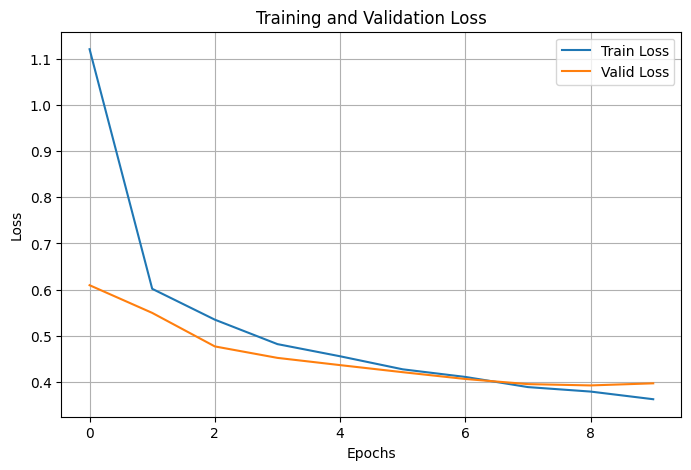

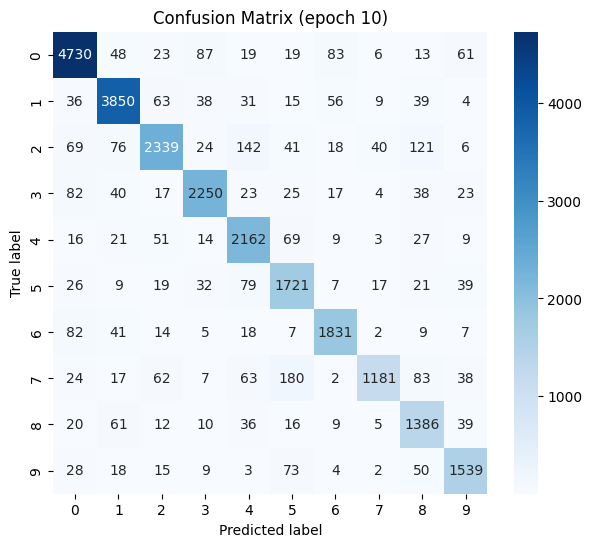

In [67]:
visualizer = NumberClassifierVisualizer(trainer.history, NUM_CLASSES)
visualizer.plot_losses()
visualizer.plot_cm()